In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from sklearn.metrics import (
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_fscore_support, 
    matthews_corrcoef, 
    cohen_kappa_score, 
    balanced_accuracy_score
)

from torch.nn.functional import softmax


In [2]:
class LoadDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        self.category_counts = {}

        for idx, row in self.img_labels.iterrows():
            img_path = os.path.join(img_dir, row['image'] + '.jpeg')
            if os.path.exists(img_path):
                self.data.append((img_path, row['level']))
                if row['level'] in self.category_counts:
                    self.category_counts[row['level']] += 1
                else:
                    self.category_counts[row['level']] = 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

class Square:
    def __call__(self, image):
        w, h = image.size
        max_wh = max(w, h)
        hp = (max_wh - w) // 2
        vp = (max_wh - h) // 2
        padding = (hp, vp, hp, vp)
        return TF.pad(image, padding, fill=0, padding_mode='constant')

transform = transforms.Compose([
    Square(),
    transforms.RandomResizedCrop((224, 224), scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

csv_file = 'multiclass_labels.csv'
img_dir = './dataset'
data = LoadDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

class_counts = data.category_counts
total_count = sum(class_counts.values())
class_weights = torch.tensor([total_count / class_counts[i] for i in range(len(class_counts))], dtype=torch.float32)
print(class_counts, total_count, class_weights)

train_size = int(0.8 * len(data))
validation_size = len(data) - train_size
train_dataset, validation_dataset = random_split(data, [train_size, validation_size], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

{0: 450, 1: 450, 4: 166, 2: 450, 3: 221} 1737 tensor([ 3.8600,  3.8600,  3.8600,  7.8597, 10.4639])


In [3]:
class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)

    def forward(self, x):
        attn = torch.sigmoid(self.conv(x))
        return x * attn

class CustomCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNNModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            Attention(512),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.network(x)

def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        model_ft = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg19":
        model_ft = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "densenet121":
        model_ft = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if use_pretrained else None)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "custom":
        model_ft = CustomCNNModel(num_classes)
        input_size = 224

    return model_ft, input_size

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [4]:
def evaluate_model(y_true, y_pred, model_outputs, num_classes):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, softmax(model_outputs), multi_class='ovo')
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=range(num_classes))
    top1_acc = topk_accuracy(torch.tensor(model_outputs), torch.tensor(y_true), k=1).item()
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)

    print(f'Confusion Matrix:\n{cnf_matrix}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    for i in range(num_classes):
        print(f"Class {i}: Precision {precision[i]:.2f}, Recall {recall[i]:.2f}, F1-Score {f1[i]:.2f}")
    print(f'Top-1 Accuracy: {top1_acc:.2f}%')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Cohen\'s Kappa: {kappa:.4f}')
    print(f'Balanced Accuracy: {balanced_acc:.4f}')

    plot_confusion_matrix(cnf_matrix, num_classes)

    return balanced_acc

def plot_confusion_matrix(cm, num_classes):
    class_names = [str(i) for i in range(num_classes)]
    cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis]
    cm_percentage = np.nan_to_num(cm_percentage)

    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(cm_percentage, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix (%)',
           ylabel='True label',
           xlabel='Predicted label')

    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.yticks(rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm_percentage[i, j]:.1%}", ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

def topk_accuracy(output, target, k=5):
    with torch.no_grad():
        maxk = min(k, output.size(1))
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        return correct_k.mul_(100.0 / target.size(0))

def ensemble_predictions(models, val_loader, num_classes, device):
    y_true = []
    all_preds = [[] for _ in models]

    with torch.no_grad():
        for inputs, labels in val_loader:
            y_true.extend(labels.cpu().numpy())
            inputs = inputs.to(device)

            for idx, model in enumerate(models):
                model.eval()
                outputs = model(inputs)
                all_preds[idx].append(outputs.cpu().numpy())

    y_true = np.array(y_true)
    all_preds = [np.vstack(preds) for preds in all_preds]
    all_preds = np.array(all_preds)

    if all_preds.shape[1] != len(y_true):
        raise ValueError(f"Predictions shape {all_preds.shape} does not match the number of true labels {len(y_true)}")

    ensemble_preds = np.mean(all_preds, axis=0)
    y_pred = np.argmax(ensemble_preds, axis=1)

    return y_true, y_pred, ensemble_preds

In [5]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train() 

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval() 
        val_running_loss = 0.0
        y_true = []
        y_pred = []
        model_outputs = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                model_outputs.extend(outputs.cpu().numpy())
        
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()
    
    return train_losses, val_losses, y_true, y_pred, model_outputs

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 5
models_list = []

Training vgg19 model...


Epoch 1/100 - Train Loss: 1.6741 - Val Loss: 1.5492
Epoch 2/100 - Train Loss: 1.5663 - Val Loss: 1.5112
Epoch 3/100 - Train Loss: 1.5719 - Val Loss: 1.4848
Epoch 4/100 - Train Loss: 1.5526 - Val Loss: 1.5048
Epoch 5/100 - Train Loss: 1.5347 - Val Loss: 1.4395
Epoch 6/100 - Train Loss: 1.4947 - Val Loss: 1.4390
Epoch 7/100 - Train Loss: 1.5116 - Val Loss: 1.4160
Epoch 8/100 - Train Loss: 1.4861 - Val Loss: 1.4396
Epoch 9/100 - Train Loss: 1.4974 - Val Loss: 1.4410
Epoch 10/100 - Train Loss: 1.4844 - Val Loss: 1.4211
Epoch 11/100 - Train Loss: 1.4380 - Val Loss: 1.4247
Epoch 12/100 - Train Loss: 1.4614 - Val Loss: 1.4153
Epoch 13/100 - Train Loss: 1.4695 - Val Loss: 1.4200
Epoch 14/100 - Train Loss: 1.4637 - Val Loss: 1.4264
Epoch 15/100 - Train Loss: 1.4692 - Val Loss: 1.3835
Epoch 16/100 - Train Loss: 1.4483 - Val Loss: 1.4162
Epoch 17/100 - Train Loss: 1.4374 - Val Loss: 1.4376
Epoch 18/100 - Train Loss: 1.4336 - Val Loss: 1.4443
Epoch 19/100 - Train Loss: 1.4332 - Val Loss: 1.4159
Ep

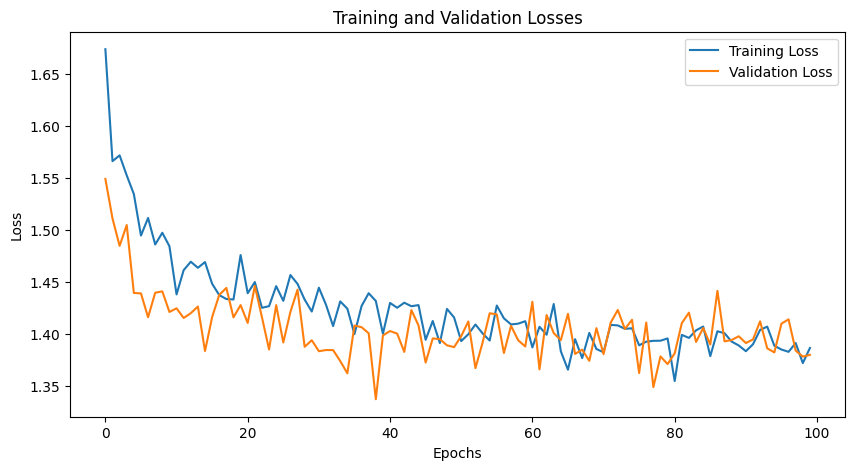

Trained model saved to vgg19_multiclass.pth
Confusion Matrix:
[[15 44 10  4  9]
 [ 7 52 13  3  8]
 [ 7 38 24 10 21]
 [ 3  9 10  9 10]
 [ 1  4  4  6 27]]
ROC AUC Score: 0.7127
Class 0: Precision 0.45, Recall 0.18, F1-Score 0.26
Class 1: Precision 0.35, Recall 0.63, F1-Score 0.45
Class 2: Precision 0.39, Recall 0.24, F1-Score 0.30
Class 3: Precision 0.28, Recall 0.22, F1-Score 0.25
Class 4: Precision 0.36, Recall 0.64, F1-Score 0.46
Top-1 Accuracy: 36.49%
Matthews Correlation Coefficient: 0.2058
Cohen's Kappa: 0.1958
Balanced Accuracy: 0.3824


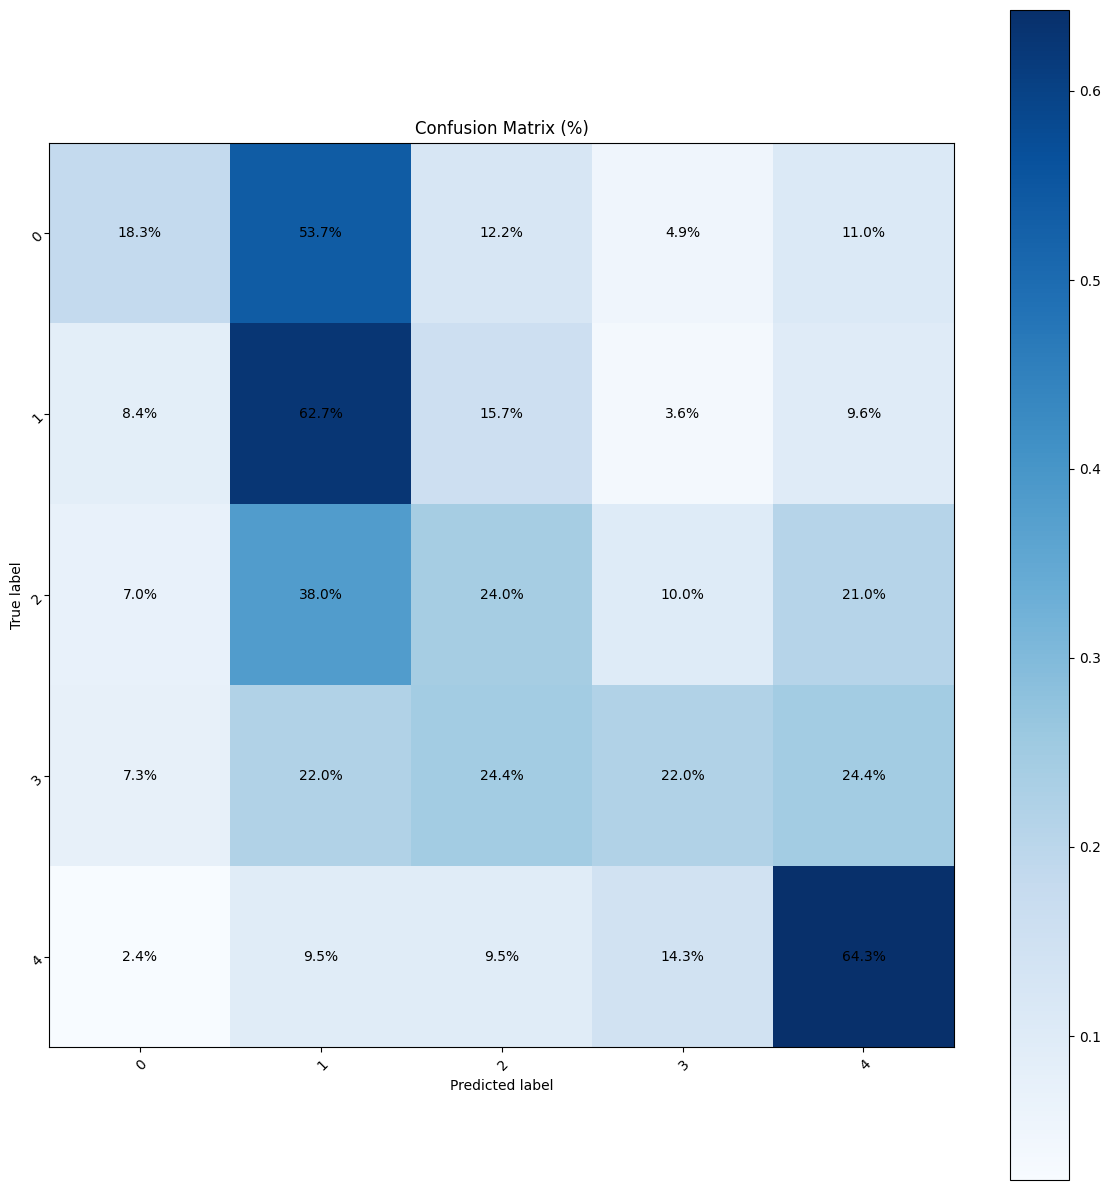

vgg19 model training and evaluation completed.



In [7]:
model_name_vgg19 = 'vgg19'
print(f"Training {model_name_vgg19} model...")

model_vgg19, input_size_vgg19 = initialize_model(model_name_vgg19, num_classes)
model_vgg19 = model_vgg19.to(device)

criterion_vgg19 = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_vgg19 = optim.Adam(model_vgg19.parameters(), lr=0.0001)

num_epochs_vgg19 = 100

train_losses_vgg19, val_losses_vgg19, y_true_vgg19, y_pred_vgg19, model_outputs_vgg19 = train_and_validate(
    model_vgg19, train_loader, validation_loader, criterion_vgg19, optimizer_vgg19, device, num_epochs=num_epochs_vgg19
)

vgg19_save_file = f"{model_name_vgg19}_multiclass.pth"
torch.save({
    'epoch': num_epochs_vgg19,
    'model_state_dict': model_vgg19.state_dict(),
    'optimizer_state_dict': optimizer_vgg19.state_dict(),
    'train_losses': train_losses_vgg19,
    'val_losses': val_losses_vgg19
}, vgg19_save_file)
print(f"Trained model saved to {vgg19_save_file}")

performance_vgg19 = evaluate_model(y_true_vgg19, y_pred_vgg19, model_outputs_vgg19, num_classes)
models_list.append(model_vgg19)
print(f"{model_name_vgg19} model training and evaluation completed.\n")

Training resnet50 model...
Epoch 1/100 - Train Loss: 1.6153 - Val Loss: 1.6205
Epoch 2/100 - Train Loss: 1.5803 - Val Loss: 1.5383
Epoch 3/100 - Train Loss: 1.5519 - Val Loss: 1.5420
Epoch 4/100 - Train Loss: 1.5317 - Val Loss: 1.5000
Epoch 5/100 - Train Loss: 1.4959 - Val Loss: 1.4964
Epoch 6/100 - Train Loss: 1.4871 - Val Loss: 1.4774
Epoch 7/100 - Train Loss: 1.4805 - Val Loss: 1.4762
Epoch 8/100 - Train Loss: 1.4518 - Val Loss: 1.4636
Epoch 9/100 - Train Loss: 1.4529 - Val Loss: 1.4530
Epoch 10/100 - Train Loss: 1.4505 - Val Loss: 1.4236
Epoch 11/100 - Train Loss: 1.4345 - Val Loss: 1.4143
Epoch 12/100 - Train Loss: 1.4383 - Val Loss: 1.4064
Epoch 13/100 - Train Loss: 1.4165 - Val Loss: 1.4516
Epoch 14/100 - Train Loss: 1.4144 - Val Loss: 1.4272
Epoch 15/100 - Train Loss: 1.4225 - Val Loss: 1.3832
Epoch 16/100 - Train Loss: 1.4119 - Val Loss: 1.4226
Epoch 17/100 - Train Loss: 1.4080 - Val Loss: 1.3830
Epoch 18/100 - Train Loss: 1.3955 - Val Loss: 1.3963
Epoch 19/100 - Train Loss: 1

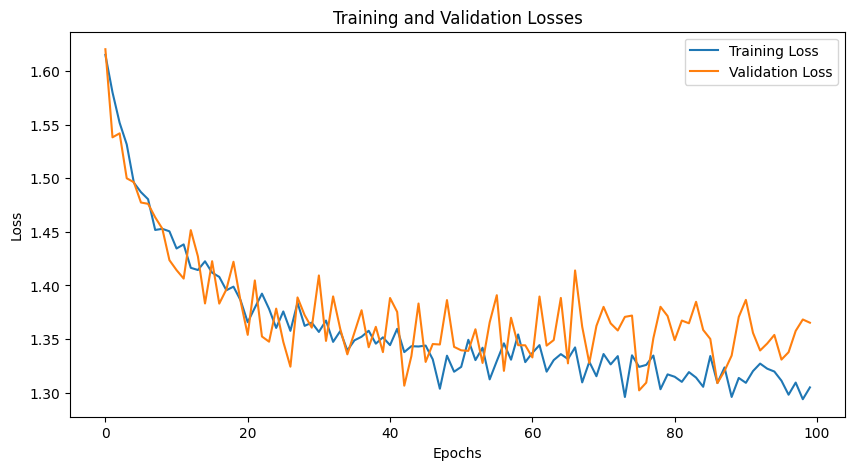

Trained model saved to resnet50_multiclass.pth
Confusion Matrix:
[[32 35  9  3  3]
 [22 37 16  4  4]
 [12 36 22 17 13]
 [ 3  8  8 15  7]
 [ 2  2  8 10 20]]
ROC AUC Score: 0.7271
Class 0: Precision 0.45, Recall 0.39, F1-Score 0.42
Class 1: Precision 0.31, Recall 0.45, F1-Score 0.37
Class 2: Precision 0.35, Recall 0.22, F1-Score 0.27
Class 3: Precision 0.31, Recall 0.37, F1-Score 0.33
Class 4: Precision 0.43, Recall 0.48, F1-Score 0.45
Top-1 Accuracy: 36.21%
Matthews Correlation Coefficient: 0.1913
Cohen's Kappa: 0.1885
Balanced Accuracy: 0.3796


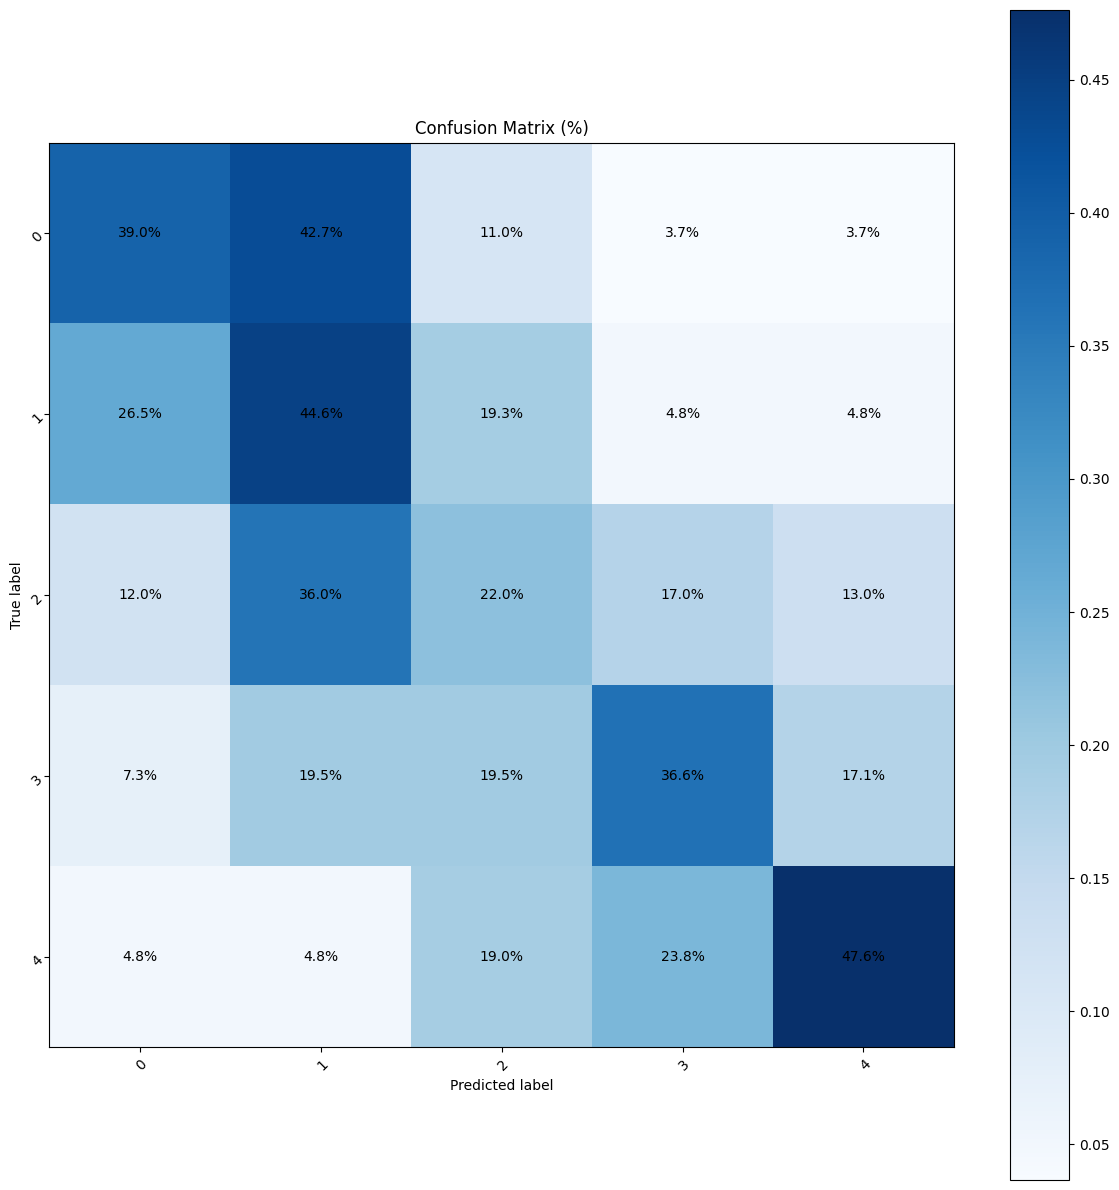

resnet50 model training and evaluation completed.



In [8]:
model_name_resnet50 = 'resnet50'
print(f"Training {model_name_resnet50} model...")

model_resnet50, input_size_resnet50 = initialize_model(model_name_resnet50, num_classes)
model_resnet50 = model_resnet50.to(device)

criterion_resnet50 = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.0001)

num_epochs_resnet50 = 100

train_losses_resnet50, val_losses_resnet50, y_true_resnet50, y_pred_resnet50, model_outputs_resnet50 = train_and_validate(
    model_resnet50, train_loader, validation_loader, criterion_resnet50, optimizer_resnet50, device, num_epochs=num_epochs_resnet50
)


resnet50_save_file = f"{model_name_resnet50}_multiclass.pth"
torch.save({
    'epoch': num_epochs_resnet50,
    'model_state_dict': model_resnet50.state_dict(),
    'optimizer_state_dict': optimizer_resnet50.state_dict(),
    'train_losses': train_losses_resnet50,
    'val_losses': val_losses_resnet50
}, resnet50_save_file)
print(f"Trained model saved to {resnet50_save_file}")

performance_resnet50 = evaluate_model(y_true_resnet50, y_pred_resnet50, model_outputs_resnet50, num_classes)
models_list.append(model_resnet50)
print(f"{model_name_resnet50} model training and evaluation completed.\n")

Training densenet121 model...
Epoch 1/100 - Train Loss: 1.6414 - Val Loss: 1.6129
Epoch 2/100 - Train Loss: 1.6078 - Val Loss: 1.5928
Epoch 3/100 - Train Loss: 1.5799 - Val Loss: 1.5747
Epoch 4/100 - Train Loss: 1.5497 - Val Loss: 1.5580
Epoch 5/100 - Train Loss: 1.5414 - Val Loss: 1.5474
Epoch 6/100 - Train Loss: 1.5134 - Val Loss: 1.5190
Epoch 7/100 - Train Loss: 1.4857 - Val Loss: 1.4845
Epoch 8/100 - Train Loss: 1.4859 - Val Loss: 1.4697
Epoch 9/100 - Train Loss: 1.5037 - Val Loss: 1.4765
Epoch 10/100 - Train Loss: 1.4627 - Val Loss: 1.4522
Epoch 11/100 - Train Loss: 1.4571 - Val Loss: 1.4424
Epoch 12/100 - Train Loss: 1.4534 - Val Loss: 1.4421
Epoch 13/100 - Train Loss: 1.4434 - Val Loss: 1.4177
Epoch 14/100 - Train Loss: 1.4426 - Val Loss: 1.4289
Epoch 15/100 - Train Loss: 1.4105 - Val Loss: 1.3952
Epoch 16/100 - Train Loss: 1.4189 - Val Loss: 1.4064
Epoch 17/100 - Train Loss: 1.4189 - Val Loss: 1.3788
Epoch 18/100 - Train Loss: 1.4146 - Val Loss: 1.3925
Epoch 19/100 - Train Loss

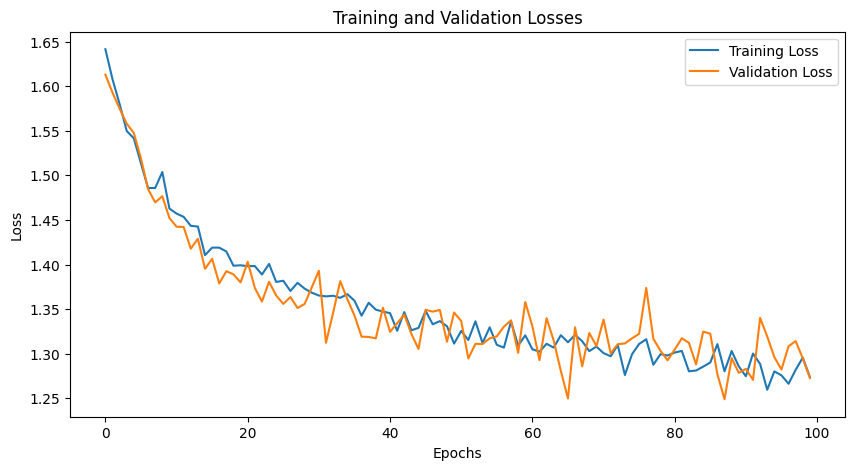

Trained model saved to densenet121_multiclass.pth
Confusion Matrix:
[[41 15 18  4  4]
 [38 22 13  5  5]
 [26 12 33 16 13]
 [ 5  3  9 16  8]
 [ 3  1  4  3 31]]
ROC AUC Score: 0.7735
Class 0: Precision 0.36, Recall 0.50, F1-Score 0.42
Class 1: Precision 0.42, Recall 0.27, F1-Score 0.32
Class 2: Precision 0.43, Recall 0.33, F1-Score 0.37
Class 3: Precision 0.36, Recall 0.39, F1-Score 0.38
Class 4: Precision 0.51, Recall 0.74, F1-Score 0.60
Top-1 Accuracy: 41.09%
Matthews Correlation Coefficient: 0.2557
Cohen's Kappa: 0.2520
Balanced Accuracy: 0.4447


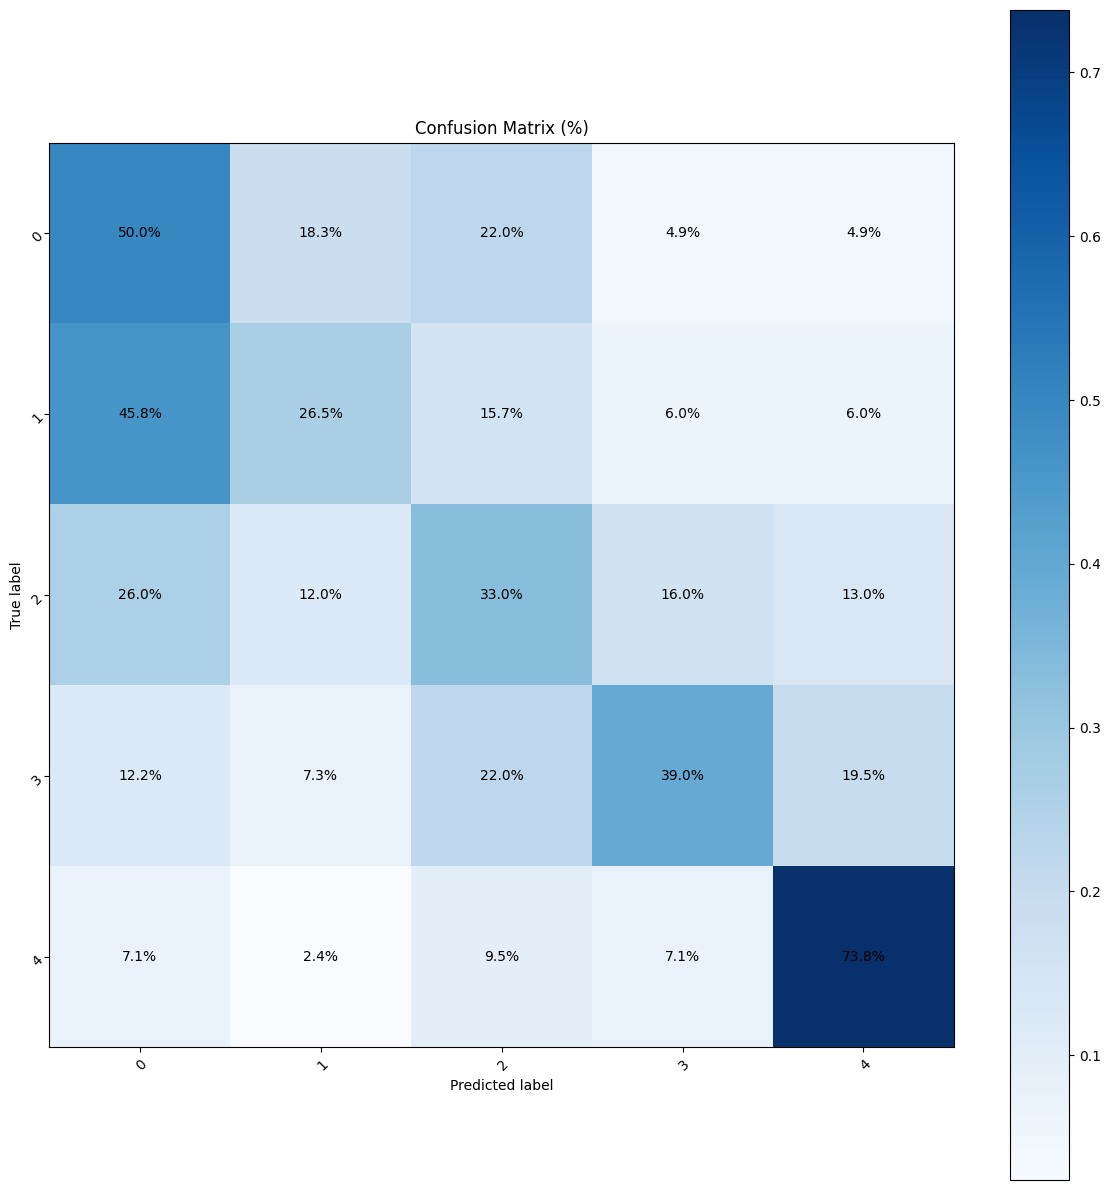

densenet121 model training and evaluation completed.



In [9]:
model_name_densenet121 = 'densenet121'
print(f"Training {model_name_densenet121} model...")

model_densenet121, input_size_densenet121 = initialize_model(model_name_densenet121, num_classes)
model_densenet121 = model_densenet121.to(device)

criterion_densenet121 = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_densenet121 = optim.Adam(model_densenet121.parameters(), lr=0.0001)

num_epochs_densenet121 = 100

train_losses_densenet121, val_losses_densenet121, y_true_densenet121, y_pred_densenet121, model_outputs_densenet121 = train_and_validate(
    model_densenet121, train_loader, validation_loader, criterion_densenet121, optimizer_densenet121, device, num_epochs=num_epochs_densenet121
)

densenet121_save_file = f"{model_name_densenet121}_multiclass.pth"
torch.save({
    'epoch': num_epochs_densenet121,
    'model_state_dict': model_densenet121.state_dict(),
    'optimizer_state_dict': optimizer_densenet121.state_dict(),
    'train_losses': train_losses_densenet121,
    'val_losses': val_losses_densenet121
}, densenet121_save_file)
print(f"Trained model saved to {densenet121_save_file}")

performance_densenet121 = evaluate_model(y_true_densenet121, y_pred_densenet121, model_outputs_densenet121, num_classes)
models_list.append(model_densenet121)
print(f"{model_name_densenet121} model training and evaluation completed.\n")

Training custom model...
Epoch 1/100 - Train Loss: 1.7312 - Val Loss: 1.6315
Epoch 2/100 - Train Loss: 1.6591 - Val Loss: 1.6258
Epoch 3/100 - Train Loss: 1.6598 - Val Loss: 1.6174
Epoch 4/100 - Train Loss: 1.6846 - Val Loss: 1.6222
Epoch 5/100 - Train Loss: 1.6759 - Val Loss: 1.6197
Epoch 6/100 - Train Loss: 1.6482 - Val Loss: 1.6203
Epoch 7/100 - Train Loss: 1.6426 - Val Loss: 1.6214
Epoch 8/100 - Train Loss: 1.6322 - Val Loss: 1.5999
Epoch 9/100 - Train Loss: 1.6679 - Val Loss: 1.6093
Epoch 10/100 - Train Loss: 1.6514 - Val Loss: 1.6129
Epoch 11/100 - Train Loss: 1.6548 - Val Loss: 1.5981
Epoch 12/100 - Train Loss: 1.6296 - Val Loss: 1.6210
Epoch 13/100 - Train Loss: 1.6520 - Val Loss: 1.5940
Epoch 14/100 - Train Loss: 1.6455 - Val Loss: 1.6012
Epoch 15/100 - Train Loss: 1.6581 - Val Loss: 1.6147
Epoch 16/100 - Train Loss: 1.6421 - Val Loss: 1.6315
Epoch 17/100 - Train Loss: 1.6409 - Val Loss: 1.6176
Epoch 18/100 - Train Loss: 1.6329 - Val Loss: 1.6186
Epoch 19/100 - Train Loss: 1.6

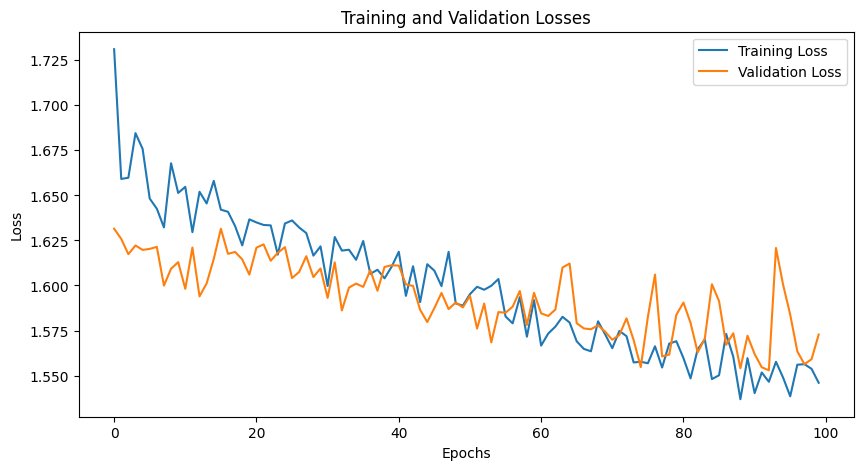

Trained model saved to custom_multiclass.pth
Confusion Matrix:
[[22 10  8 15 27]
 [22 13  5 12 31]
 [13  7 17 13 50]
 [ 6  4  7  6 18]
 [ 5  5  5  3 24]]
ROC AUC Score: 0.5834
Class 0: Precision 0.32, Recall 0.27, F1-Score 0.29
Class 1: Precision 0.33, Recall 0.16, F1-Score 0.21
Class 2: Precision 0.40, Recall 0.17, F1-Score 0.24
Class 3: Precision 0.12, Recall 0.15, F1-Score 0.13
Class 4: Precision 0.16, Recall 0.57, F1-Score 0.25
Top-1 Accuracy: 23.56%
Matthews Correlation Coefficient: 0.0792
Cohen's Kappa: 0.0723
Balanced Accuracy: 0.2625


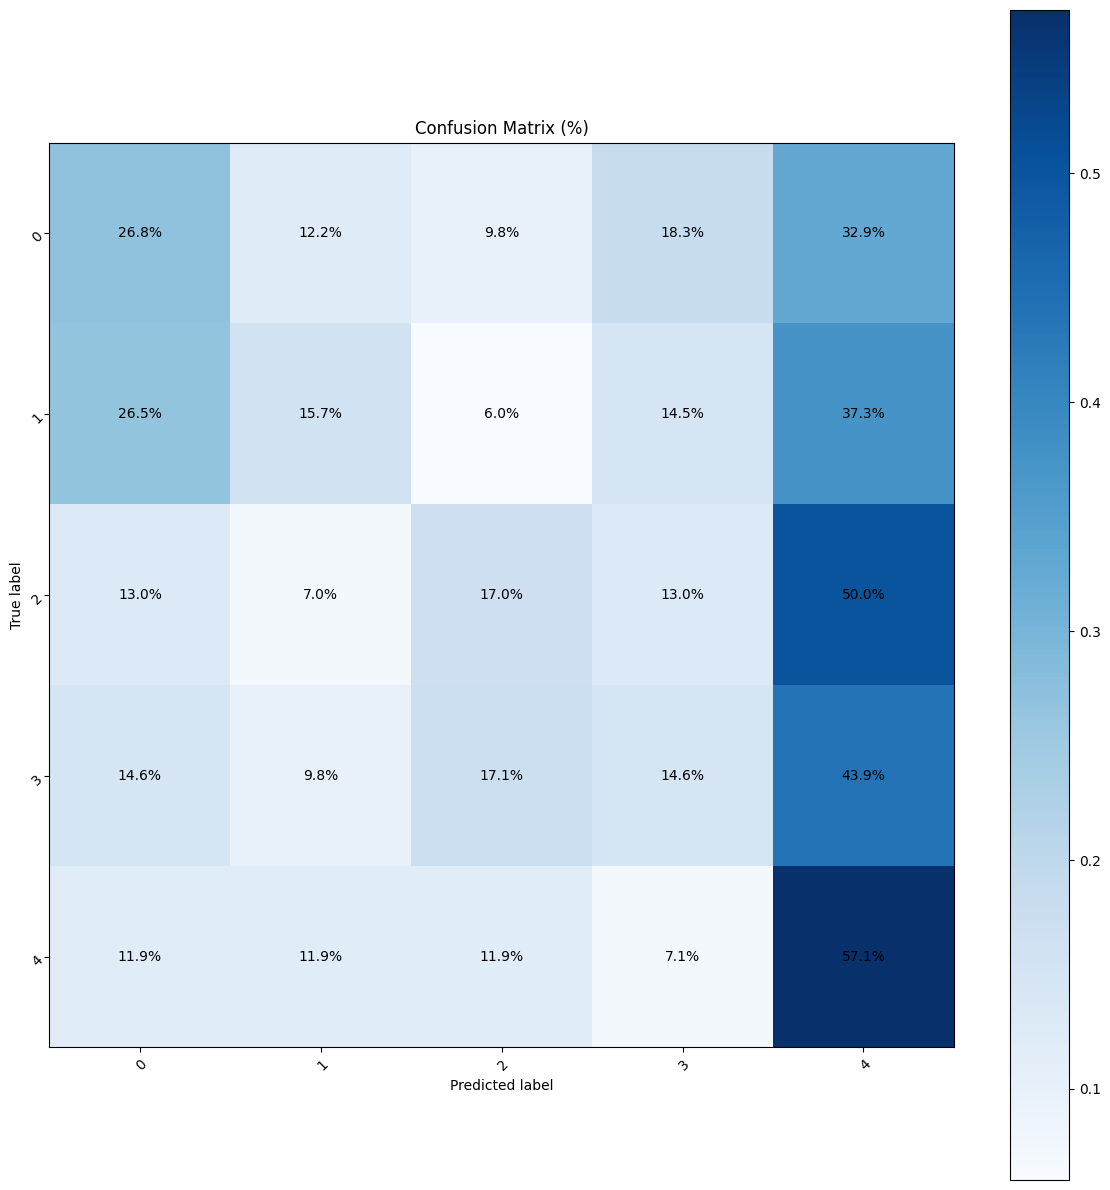

custom model training and evaluation completed.



In [10]:
model_name_custom = 'custom'
print(f"Training {model_name_custom} model...")

model_custom, input_size_custom = initialize_model(model_name_custom, num_classes)
model_custom = model_custom.to(device)

criterion_custom = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.0001)

num_epochs_custom = 100

train_losses_custom, val_losses_custom, y_true_custom, y_pred_custom, model_outputs_custom = train_and_validate(
    model_custom, train_loader, validation_loader, criterion_custom, optimizer_custom, device, num_epochs=num_epochs_custom
)

custom_save_file = f"{model_name_custom}_multiclass.pth"
torch.save({
    'epoch': num_epochs_custom,
    'model_state_dict': model_custom.state_dict(),
    'optimizer_state_dict': optimizer_custom.state_dict(),
    'train_losses': train_losses_custom,
    'val_losses': val_losses_custom
}, custom_save_file)
print(f"Trained model saved to {custom_save_file}")

performance_custom = evaluate_model(y_true_custom, y_pred_custom, model_outputs_custom, num_classes)
models_list_custom = models_list
models_list_custom.append(model_custom)
print(f"{model_name_custom} model training and evaluation completed.\n")

Confusion Matrix:
[[37 25  9  3  8]
 [35 31 12  1  4]
 [23 20 31 12 14]
 [ 7  4  6 18  6]
 [ 3  0  5  4 30]]
ROC AUC Score: 0.7845
Class 0: Precision 0.35, Recall 0.45, F1-Score 0.40
Class 1: Precision 0.39, Recall 0.37, F1-Score 0.38
Class 2: Precision 0.49, Recall 0.31, F1-Score 0.38
Class 3: Precision 0.47, Recall 0.44, F1-Score 0.46
Class 4: Precision 0.48, Recall 0.71, F1-Score 0.58
Top-1 Accuracy: 42.24%
Matthews Correlation Coefficient: 0.2700
Cohen's Kappa: 0.2667
Balanced Accuracy: 0.4576


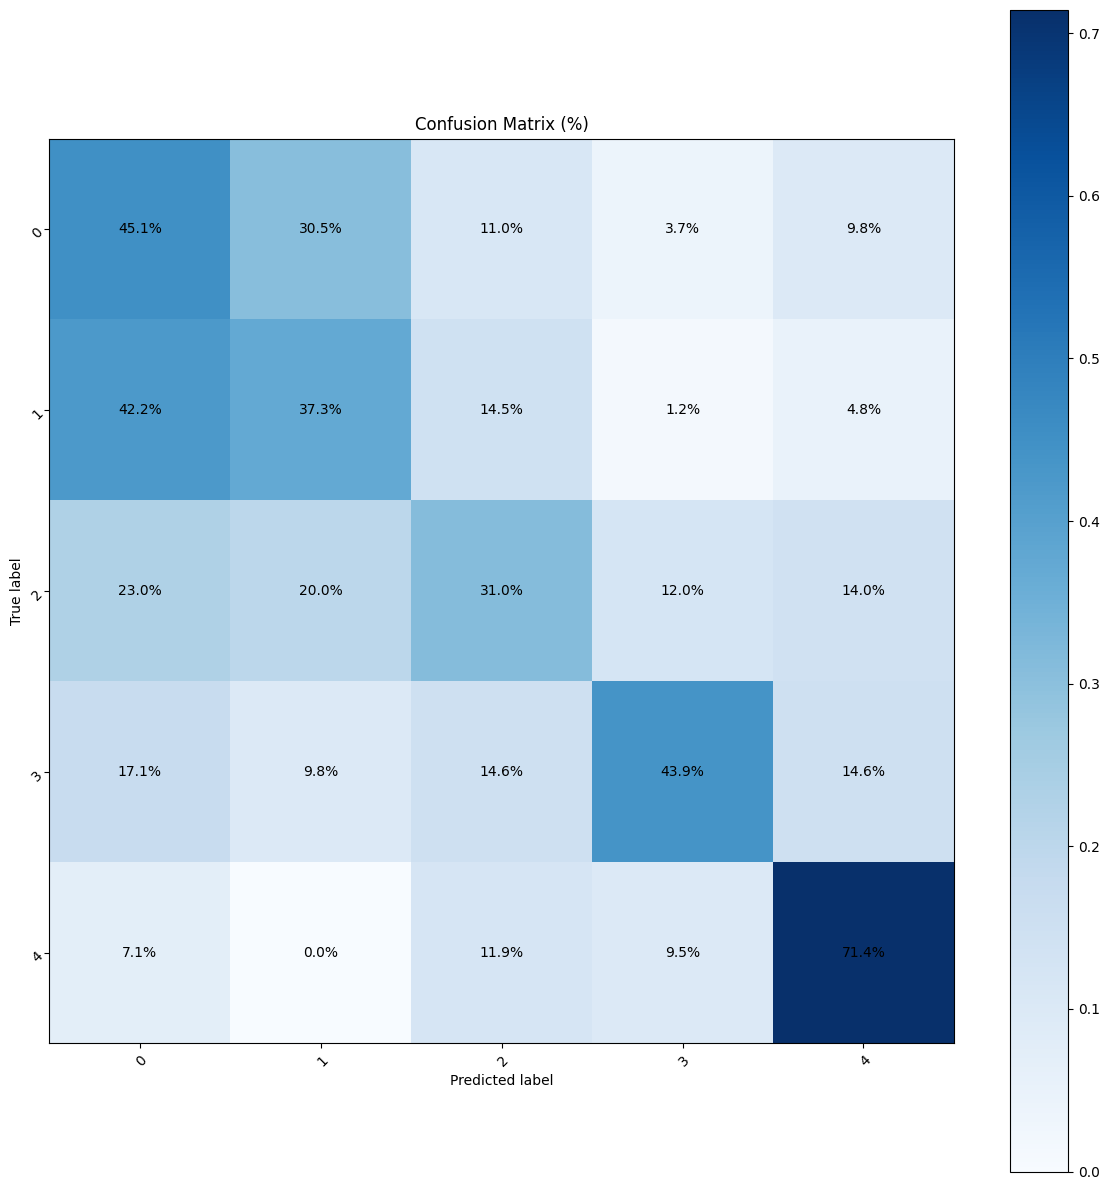

In [11]:
ensemble_y_true, ensemble_y_pred, ensemble_outputs = ensemble_predictions(models_list, validation_loader, num_classes, device)
evaluate_model(ensemble_y_true, ensemble_y_pred, ensemble_outputs, num_classes)

Confusion Matrix:
[[33 26 11  3  9]
 [31 34 13  1  4]
 [17 28 32  5 18]
 [ 6  4  5 16 10]
 [ 2  2  4  4 30]]
ROC AUC Score: 0.7665
Class 0: Precision 0.37, Recall 0.40, F1-Score 0.39
Class 1: Precision 0.36, Recall 0.41, F1-Score 0.38
Class 2: Precision 0.49, Recall 0.32, F1-Score 0.39
Class 3: Precision 0.55, Recall 0.39, F1-Score 0.46
Class 4: Precision 0.42, Recall 0.71, F1-Score 0.53
Top-1 Accuracy: 41.67%
Matthews Correlation Coefficient: 0.2623
Cohen's Kappa: 0.2590
Balanced Accuracy: 0.4473


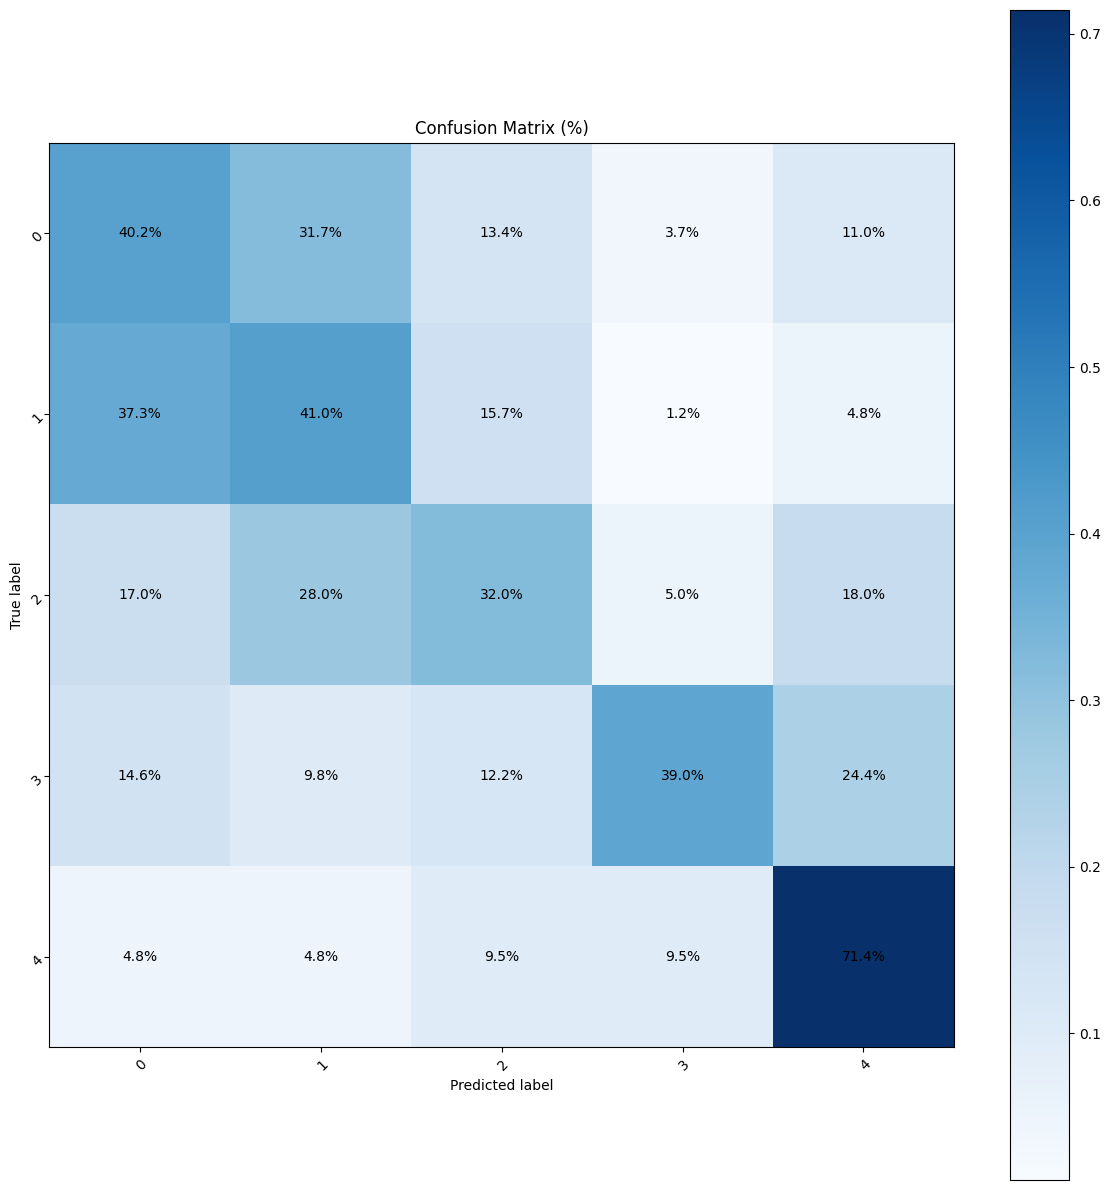

In [12]:
ensemble_y_true, ensemble_y_pred, ensemble_outputs = ensemble_predictions(models_list_custom, validation_loader, num_classes, device)
evaluate_model(ensemble_y_true, ensemble_y_pred, ensemble_outputs, num_classes)